In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

In [5]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models

import numpy as np
import random

# from src.models.resnet import ResNet50
from src.norm.norm_layer import replace_norm_layer
from src.data.loaders import get_cifar_loader
from src.models.vgg import VGG16

from torchsummary import summary
from tqdm import tqdm

from IPython import display

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [8]:
def get_accuracy(model, dataloader, device='gpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [9]:
def get_loss(model, dataloader, criterion, device='gpu'):
    loss_ = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            loss = criterion(prediction, y)
            loss_ += loss.item()
    return loss / len(dataloader)

In [10]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    val_learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()

        learning_curve[epoch] = 0
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)
        
        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        val_learning_curve[epoch] = get_loss(model, val_loader, criterion, device)
        axes[0].plot(val_learning_curve)
        axes[0].set_title('LT {:.4f}, LV {:.4f}'.format(
            learning_curve[epoch], val_learning_curve[epoch]))

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
        
    return learning_curve, val_learning_curve, train_accuracy_curve, val_accuracy_curve

In [11]:
batch_size = 128
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
training_results_vgg16 = {}

# GN + Regularization

In [18]:
vgg16_gn = VGG16(norm='gn_regularization').to(device)

In [19]:
print(vgg16_gn)

VGG16(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm2d()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (stage4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1,

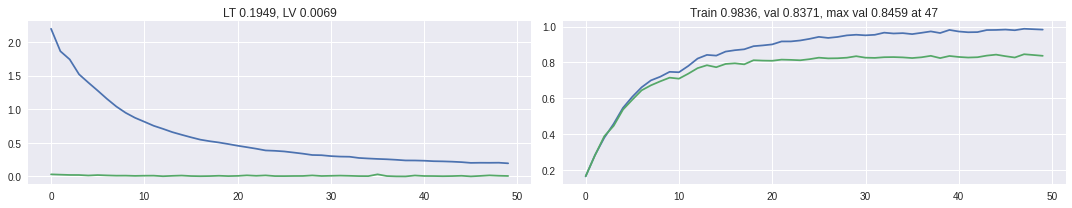

100%|██████████| 50/50 [18:14<00:00, 21.88s/epoch]


In [20]:
lr = 1e-3
model_name = '2_vgg16_gn_regularization'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = vgg16_gn

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

# BN Regularization

In [24]:
vgg16_bn = VGG16(norm='bn_regularization').to(device)

In [25]:
print(vgg16_bn)

VGG16(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=

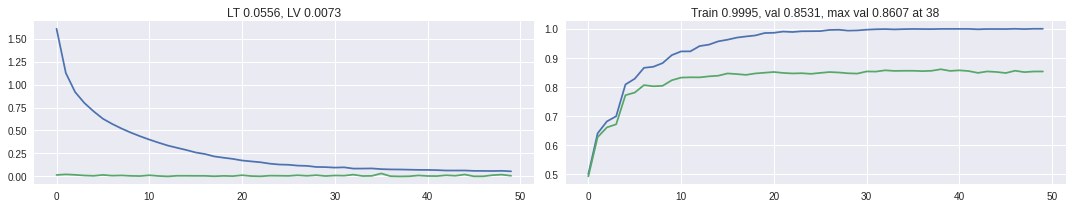

100%|██████████| 50/50 [15:08<00:00, 18.17s/epoch]


In [26]:
lr = 1e-3
model_name = '2_vgg16_bn_regularization'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = vgg16_bn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## Regularization Only

In [27]:
vgg16 = VGG16(norm='regularization', mean=0.001, std=1.001).to(device)

In [28]:
print(vgg16)

VGG16(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Identity()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (stage4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding

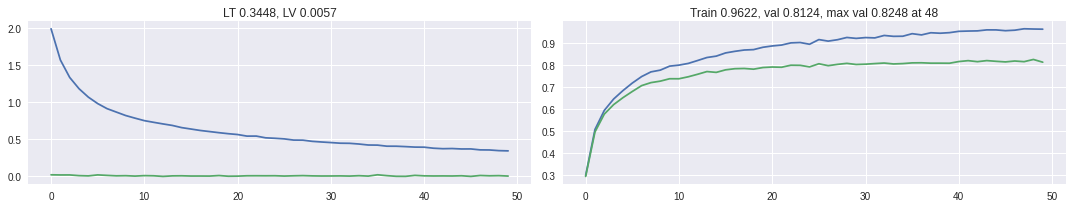

100%|██████████| 50/50 [14:03<00:00, 16.88s/epoch]


In [29]:
lr = 1e-3
model_name = '2_vgg16_regularization'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = vgg16

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

In [32]:
training_results = {}
training_results['vgg16_regularization_lr_0.001'] = training_results_vgg16['2_vgg16_regularization_lr_0.001']
training_results['vgg16_bn_regularization_lr_0.001'] = training_results_vgg16['2_vgg16_bn_regularization_lr_0.001']
training_results['vgg16_gn_regularization_lr_0.001'] = training_results_vgg16['2_vgg16_gn_regularization_lr_0.001']
# training_results['vgg16_bn_noisy_small_lr_0.001'] = training_results_vgg16['1_vgg16_bn_noisy_small_lr_0.001']
# training_results['vgg16_bn_noisy_big_lr_0.001'] = training_results_vgg16['1_vgg16_bn_noisy_big_lr_0.001']

/home/kaist/anaconda3/envs/assn2/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


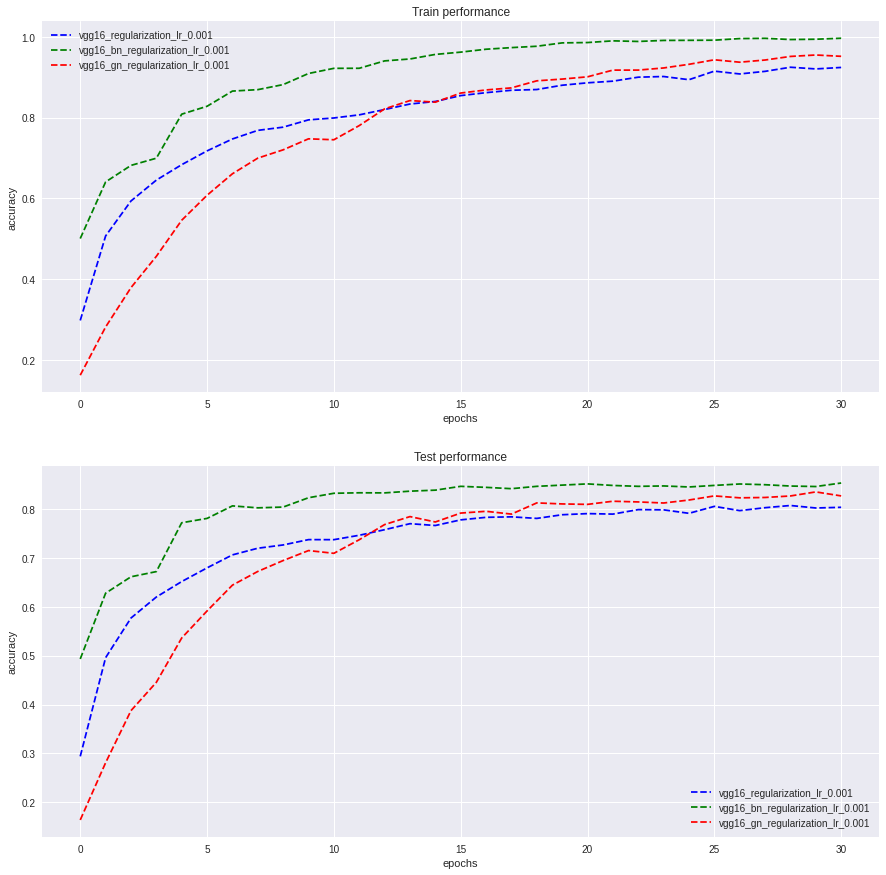

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

for exp_name, result in training_results.items():
    learning_curve, _, train_accuracy_curve, val_accuracy_curve = result
    
    if '0.001' in exp_name:
        if 'gn_regularization' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'r--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'r--', label=exp_name)
        elif 'bn_regularization' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'g--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'g--', label=exp_name)
        else:
            axs[0].plot(train_accuracy_curve[:31], 'b--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'b--', label=exp_name)

axs[0].set_title('Train performance')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()

axs[1].set_title('Test performance')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.savefig(os.path.join(figures_path, 'comparison_gn_vgg16.png'), dpi=500, quality=100)
plt.show()

In [34]:
import pickle
def save_obj(obj, name ):
    with open('../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [35]:
save_obj(training_results, 'regularization_result')

In [36]:
test = load_obj('regularization_result')